In [2]:
from sentinelsat import SentinelAPI, make_path_filter # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nyc_geo = gpd.read_file('data/manhattan/POLYGON.shp')

In [4]:
#m = folium.Map([40.730610, -73.935242], zoom_start=10) # New York City


In [5]:
#folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
#m

In [6]:
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

In [9]:
products = api.query(footprint,
                     date = ('20220101', '20220905'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [10]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted.shape

(23, 41)

In [ ]:

# define the filter function to select files (to be excluded in this case)
path_filter = make_path_filter("*measurement/*", exclude=True)

In [11]:
def get_bands(imagery_folders):
    for imagery in imagery_folders:
        l2a_folder = os.listdir(f'{imagery}/GRANULE')[0]
        r10_path = f"{imagery}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
        for band in os.listdir(r10_path):
        # extract bands 2,3, and 4 from r10:

            if 'B02' in band:
                b2 = rio.open(f"{r10_path}/{band}")
            elif 'B03' in band:
                b3 = rio.open(f"{r10_path}/{band}")
            elif 'B04' in band:
                b4 = rio.open(f"{r10_path}/{band}")

    return b2, b3, b4

Extracted all


/Users/noahkasmanoff/anaconda3/envs/nasaeo/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Extracted all


/Users/noahkasmanoff/anaconda3/envs/nasaeo/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Extracted all


/Users/noahkasmanoff/anaconda3/envs/nasaeo/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


KeyboardInterrupt: 

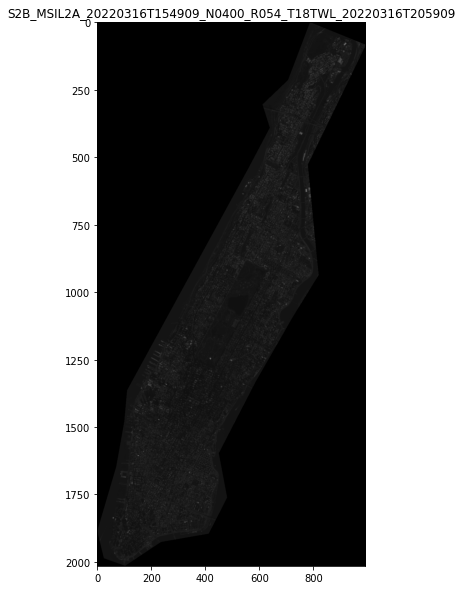

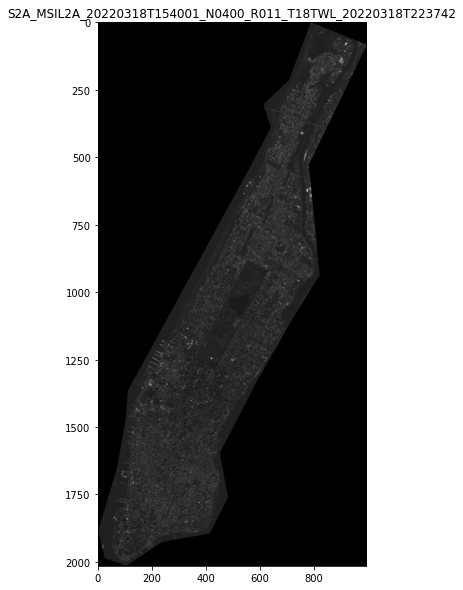

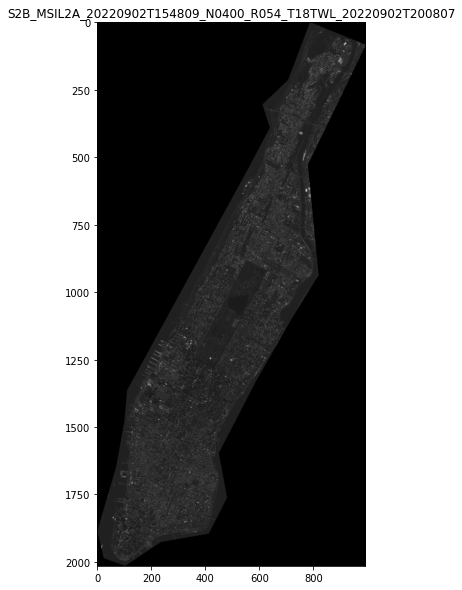

In [12]:
for product_id in products_gdf_sorted.index:

    is_online = api.is_online(product_id)
    if is_online:
        downloaded_artifact = api.download(product_id)
    else:
        continue
    zip_file = downloaded_artifact['path']

    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall()
            print("Extracted all")
    except:
        print("Invalid file")

    imagery_folders = [x for x in os.listdir() if x.endswith('SAFE')]

    b2, b3, b4 = get_bands(imagery_folders)



    # this will take a while on the Nano..
    with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
                count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
        rgb.write(b2.read(1),1) 
        rgb.write(b3.read(1),2) 
        rgb.write(b4.read(1),3) 
        rgb.close()


    with rio.open("RGB.tiff") as src:
        out_meta = src.meta.copy()
        nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
        out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})
        
    with rasterio.open(f"{downloaded_artifact['title']}.tiff", "w", **out_meta) as dest:
        dest.write(out_image)

    os.remove("RGB.tiff")

    try:
        os.remove("RGB.tiff")
        os.remove(downloaded_artifact['path'])
    except Exception as e:
        pass
    plt.figure(figsize=(5,10))    
    plt.title(downloaded_artifact['title'])
    plt.imshow(out_image[0],cmap='gray')

In [49]:
rasters = []
for f in os.listdir():
    if '.tiff' in f:
        print(f)
        src = rio.open(f).read()
        rasters.append(src)


S2A_MSIL2A_20220318T154001_N0400_R011_T18TWL_20220318T223742.tiff
S2B_MSIL2A_20220316T154909_N0400_R054_T18TWL_20220316T205909.tiff
S2B_MSIL2A_20220902T154809_N0400_R054_T18TWL_20220902T200807.tiff


In [39]:
src.shape

(3, 2015, 994)

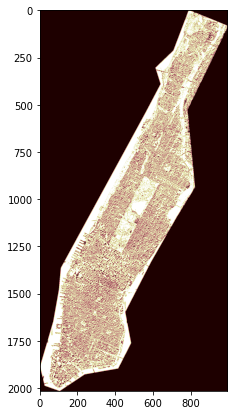

In [48]:
plt.figure(figsize=(25,7))
plt.imshow(rasters[0][0] - rasters[1][0] ,cmap='pink')

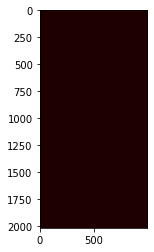

In [53]:
plt.imshow(rasters[1][0] - rasters[1][0] ,cmap='pink')